# NYC Yellow Taxi Trip Demand Analysis & Forecasting

## Goal

My primary goal of this analysis is to help taxi drivers and fleet managers **maximize revenue and operational efficiency** by uncovering insights from historical trip data and building a machine learning model to **forecast future trip demand**.

## Key Questions

Through this project, I aim to answer the following business-critical questions:

- **When** is taxi demand highest?
- **Where** are the most frequent pickup and drop-off locations?
- **How far** are people typically traveling?
- **What types of trips** generate the most revenue?
- **Can we forecast** future demand to help drivers position themselves better?

## Approach

To answer these questions, I will:

- Clean and preprocess the raw trip data
- Perform exploratory data analysis (EDA) using the **TDR framework** (Time, Distance, Revenue)
- Engineer time-based and lag features
- Train and evaluate an **XGBoost regression model** to forecast **next-day trip demand**
- Summarize insights and provide actionable recommendations for taxi operations



#### Task 1: Data Cleaning
Missing values were handled using appropriate imputations (like mode for categorical, 0 for surcharges).
Datetime fields were converted, and data types were adjusted for analysis.
Initial exploration and summary statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load and Preview Data
df = pd.read_csv("Yellow_Taxi_Assignment.csv", parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


In [ ]:
# Load location lookup data
location_df = pd.read_csv('taxi_zone_lookup.csv')  
location_df.head()


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [ ]:
#I have used the data dictionary csv for taxi zones toget names which would be easier to interpret than just IDs.

# Merge pickup location info
df = df.merge(
    location_df,
    how='left',
    left_on='PULocationID',
    right_on='LocationID'
)

# Rename columns 
df.rename(columns={
    'Borough': 'pickup_borough',
    'Zone': 'pickup_zone',
    'service_zone': 'pickup_service_zone'
}, inplace=True)

# Merge drop-off location info
df = df.merge(
    location_df,
    how='left',
    left_on='DOLocationID',
    right_on='LocationID'
)

df.rename(columns={
    'Borough': 'dropoff_borough',
    'Zone': 'dropoff_zone',
    'service_zone': 'dropoff_service_zone'
}, inplace=True)

In [10]:
# Summary of numerical columns
df.describe()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,304978.000000,304978,304978,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000
mean,1.672786,2020-07-16 11:54:50.074785792,2020-07-16 12:11:31.905307648,1.464181,4.587589,1.138472,163.744975,160.988898,1.240463,13.510189,0.903506,0.492755,2.224064,0.390715,0.312725,19.050501,1.707790,0.029887
min,1.000000,2018-01-01 00:25:49,2018-01-01 00:38:59,0.000000,-16.860000,1.000000,1.000000,1.000000,0.000000,-197.000000,-6.000000,-0.500000,-20.000000,-13.750000,-1.000000,-198.550000,-2.500000,-1.250000
25%,1.000000,2019-04-08 09:18:22.500000,2019-04-08 09:32:34.750000128,1.000000,1.000000,1.000000,121.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,10.800000,0.000000,0.000000
50%,2.000000,2020-07-17 17:01:39,2020-07-17 17:17:55,1.000000,1.730000,1.000000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.860000,0.000000,0.300000,14.300000,2.500000,0.000000
75%,2.000000,2021-10-24 11:29:50.500000,2021-10-24 11:42:53.249999872,1.000000,3.210000,1.000000,234.000000,234.000000,2.000000,15.000000,1.000000,0.500000,2.950000,0.000000,0.300000,20.760000,2.500000,0.000000
max,6.000000,2023-01-31 23:57:28,2023-02-01 00:09:12,6.000000,177247.400000,99.000000,265.000000,265.000000,5.000000,455.000000,18.500000,2.540000,115.560000,96.550000,1.000000,561.490000,2.750000,1.250000
std,0.514069,NaN,NaN,1.094009,434.226624,2.923360,66.570490,70.975905,0.528257,12.636651,1.185321,0.074023,2.765200,1.699547,0.110404,15.464014,1.178751,0.192431


In [11]:
# Summary of categorical columns
df.describe(include='object')


,store_and_fwd_flag
count,304978
unique,2
top,N
freq,301938


In [13]:
#Unique Values per Column
df.nunique().sort_values()


store_and_fwd_flag            2
airport_fee                   3
improvement_surcharge         5
congestion_surcharge          5
VendorID                      5
payment_type                  6
RatecodeID                    7
passenger_count               7
mta_tax                      12
extra                        48
PULocationID                249
DOLocationID                259
tolls_amount                260
tip_amount                 1984
trip_distance              2838
fare_amount                3842
total_amount               6825
tpep_dropoff_datetime    304584
tpep_pickup_datetime     304602
dtype: int64

In [15]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Create trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60


In [ ]:
#missing values
df.isnull().sum()


VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count            9513
trip_distance                 0
RatecodeID                 9513
store_and_fwd_flag         9513
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge      72632
airport_fee              198761
dtype: int64

In [ ]:
# Missing value imputations

# Fill with mode 
#Assumption:Most passengers are solo riders hence  mode for passenger_count
df['passenger_count'].fillna(df['passenger_count'].mode()[0], inplace=True)

# Fill with mode
#assumption: Most trips are standard rate hence  mode for RatecodeID
df['RatecodeID'].fillna(df['RatecodeID'].mode()[0], inplace=True)

# Fill with 'N' (not stored — most common)
#assumption:Most trips are not stored hence 'N' for store_and_fwd_flag
df['store_and_fwd_flag'].fillna('N', inplace=True)

# Fill with 0 : means no surcharge applied
#assumption:Most trips don’t include airport fee
df['congestion_surcharge'].fillna(0, inplace=True)

# Fill with 0 : not an airport pickup
#assumption:Most trips don’t include airport fee
df['airport_fee'].fillna(0, inplace=True)


In [9]:
df.isnull().sum()



VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

In [ ]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_30min'] = df['tpep_pickup_datetime'].dt.floor('30min')


day_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

df['pickup_day'] = df['pickup_day'].map(day_map)


### Task 2: For the Exploratory Data Analysis and trends I will be focusing on the TDR(Time, Distance, Revenue) framework where:
1. time: When do trips happen? (hour, day, weekday, season)
2. Distance: How far are people traveling? popular spots
3. Revenue: How much money is generated per trip/time/location?



### Time Based Analysis:

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Create time-based features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.dayofweek  
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date

df['pickup_season'] = df['pickup_month'] % 12 // 3 + 1
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['pickup_season'] = df['pickup_season'].map(season_map)

# Weekday names
weekday_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}
df['pickup_weekday_name'] = df['pickup_weekday'].map(weekday_map)


#### Trips per Hour of Day 
The distribution of trips across hours of the day reveals clear peak and off-peak patterns:

- Peak hours occur between 2 PM and 6 PM, with the highest number of trips at 5 PM (roughly 19,600 trips).
- Morning activity begins increasing from 6 AM, with a noticeable rise through 9–11 AM.
- Late night and early morning hours (12 AM–5 AM) have significantly lower demand, with the lowest at 4 AM ( roughly 2,000 trips).
- Overall, trip volume steadily increases throughout the day, peaking in the afternoon and early evening before tapering off at night.

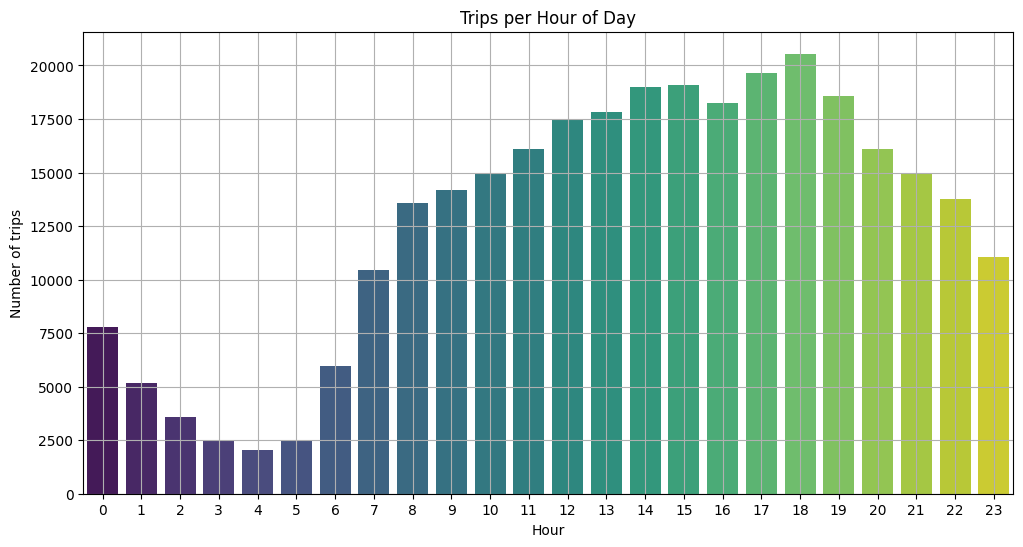

In [ ]:
#Trips per Hour of Day
plt.figure(figsize=(12,6))
sns.countplot(x='pickup_hour', data=df, palette='viridis')
plt.title('Trips per Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of trips')
plt.grid(True)
plt.show()


#### Trips per Day of the Week 
The trip volume varies across the week, showing both weekday and weekend demand patterns:

- Friday has the highest number of trips (47,373), closely followed by Thursday (roughly 47,00) and Wednesday ( roughly 46,400), indicating strong demand toward the end of the workweek.
- Monday has the lowest weekday volume (roughly 40,000), suggesting a slower start to the week.
- Saturday also shows high activity (roughly 43,000), while Sunday has the lowest overall trip count ( roughly 35,800), indicating reduced weekend demand.
- Overall, weekdays are busier than weekends, with peak activity mid-to-late in the week.

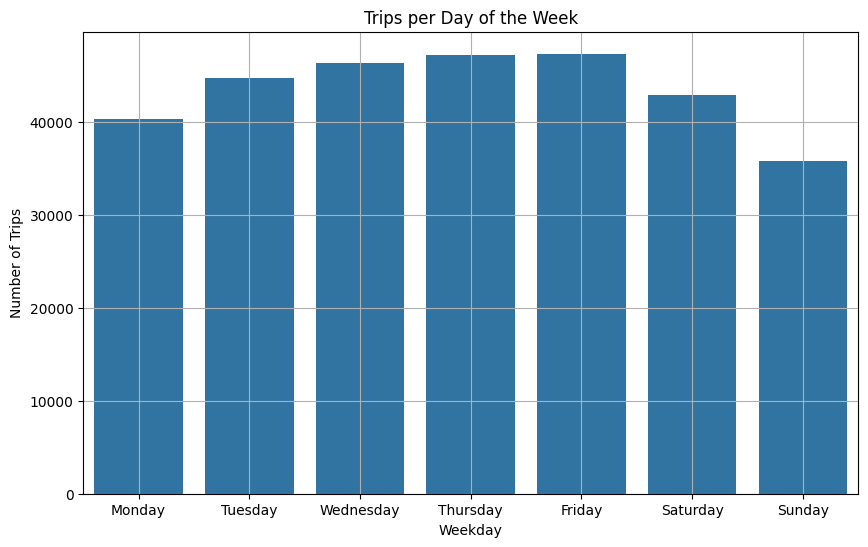

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_weekday_name', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Trips per Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


#### Heatmap: Trips by Hour and Day of the Week 
The heatmap reveals clear temporal patterns in taxi demand across different days and hours:

- firstly Weekday mornings (7 AM–10 AM) show steady demand, with a sharp increase starting at 7 AM, peaking around 9–11 AM.
- Afternoon and early evening hours (2 PM–7 PM) consistently have the highest trip volumes across all days, especially on Fridays and Thursdays.
- Late-night and early-morning hours (12 AM–5 AM) show significantly fewer trips, with Sunday and Monday early mornings being the lowest.
- Friday is the busiest day overall, with consistently high demand from morning through late evening.
- Weekends (Saturday and Sunday) show a delayed demand start, with higher activity in the afternoon and evening suggesting leisure-related travel.

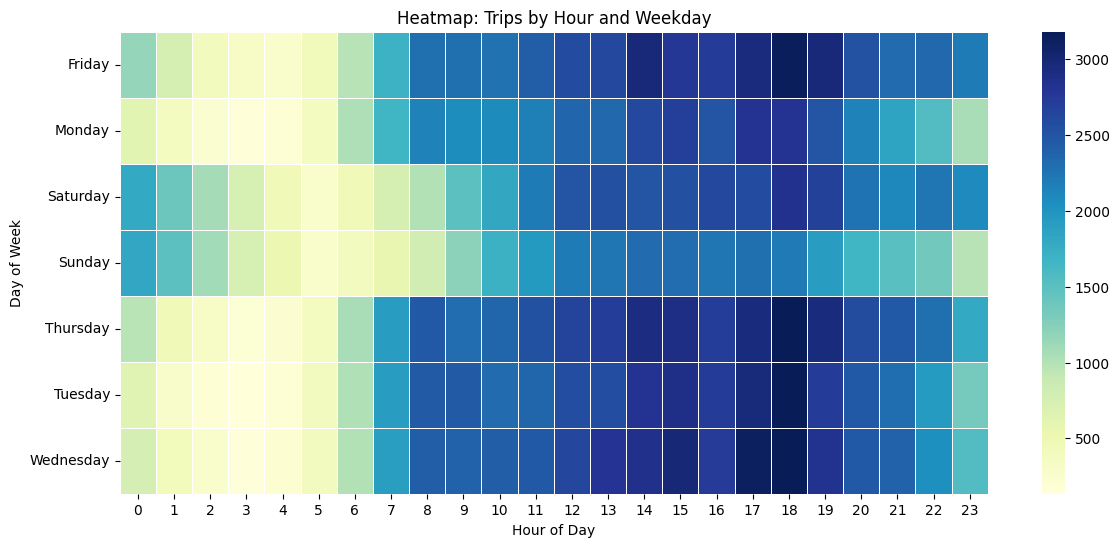

In [31]:
heatmap_data = df.groupby(['pickup_weekday_name', 'pickup_hour']).size().unstack()

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap: Trips by Hour and Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


### Distance Based Analysis:

#### Top Pickup-Dropoff Zone Pairs 
The most frequent travel routes are highly concentrated within Manhattan, particularly in the Upper East Side and Upper West Side areas:

- The most common route is from Upper East Side South to Upper East Side North with 2,069 trips, followed closely by the reverse direction.
- Several routes are  between adjacent neighborhoods, indicating high demand for short, localized trips.
- Other popular routes include Midtown Center to Upper East Side South and Lincoln Square East to Upper West Side South, reflecting common residential and commercial travel corridors.

These insights showsthe importance of short-distance high-frequency trips in densely populated Manhattan neighborhoods

In [45]:
top_routes = df.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='trip_count')
top_routes = top_routes.sort_values(by='trip_count', ascending=False).head(10)
top_routes


,pickup_zone,dropoff_zone,trip_count
12155,Upper East Side South,Upper East Side North,2069
11997,Upper East Side North,Upper East Side South,1673
11996,Upper East Side North,Upper East Side North,1525
12156,Upper East Side South,Upper East Side South,1422
12425,Upper West Side South,Upper West Side North,863
12376,Upper West Side South,Lincoln Square East,817
12292,Upper West Side North,Upper West Side South,773
8039,Midtown Center,Upper East Side South,756
6749,Lenox Hill West,Upper East Side North,752
6895,Lincoln Square East,Upper West Side South,745


#### Average Trip Distance by Hour of Day
The analysis of average trip distance across different hours of the day reveals a few notable patterns:

- Early morning hours (2 AM and 6 AM) show unusually high average distances (33 miles), likely due to airport runs or longer inter-borough trips when traffic is minimal.
- Midday to evening hours (10 AM to 6 PM) have the shortest average distances, roughly around 2.8 to 3.2 miles, suggesting a high volume of short, local trips within the city.
- Late night (10 PM–1 AM) and early morning (4–5 AM) hours show a moderate increase in trip distance, possibly due to longer return trips or fewer short-distance riders.
- Overall, the data reflects a mix of short intracity travel during the day and longer trips during off-peak hours, especially at night and early morning.

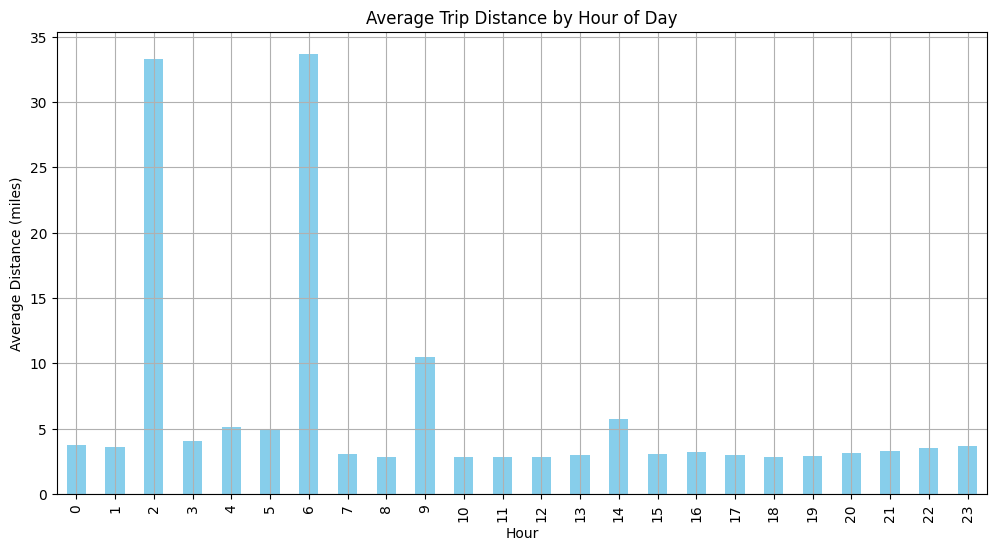

In [51]:
avg_distance_by_hour = df.groupby('pickup_hour')['trip_distance'].mean()

plt.figure(figsize=(12, 6))
avg_distance_by_hour.plot(kind='bar', color='skyblue')
plt.title('Average Trip Distance by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Distance (miles)')
plt.grid(True)
plt.show()


#### Trip Distance CategoriesSummary
Trips were segmented into five distance-based categories to better understand rider behavior:

- The majority of trips fall into the Short (1–3 miles) category (149,972 trips), followed by Very Short (<1 mile) trips (71,267 trips), indicating that most taxi rides are brief and local.
- Medium-distance trips (3–7 miles) account for 51,332 trips, often representing inter-neighborhood travel.
- Long (7–15 miles) and veryLong (>15 miles) trips are less frequent, with 21,470 and 10,937 trips respectively, typically representing airport runs or inter-borough travel.

This distribution highlights the dominance of short-distance, high-frequency trips in the dataset.

In [50]:
def categorize_distance(d):
    if d < 1:
        return 'Very Short'
    elif d < 3:
        return 'Short'
    elif d < 7:
        return 'Medium'
    elif d < 15:
        return 'Long'
    else:
        return 'Very Long'

df['distance_category'] = df['trip_distance'].apply(categorize_distance)

df['distance_category'].value_counts()


distance_category
Short         149972
Very Short     71267
Medium         51332
Long           21470
Very Long      10937
Name: count, dtype: int64

### Revenue Based Analysis:

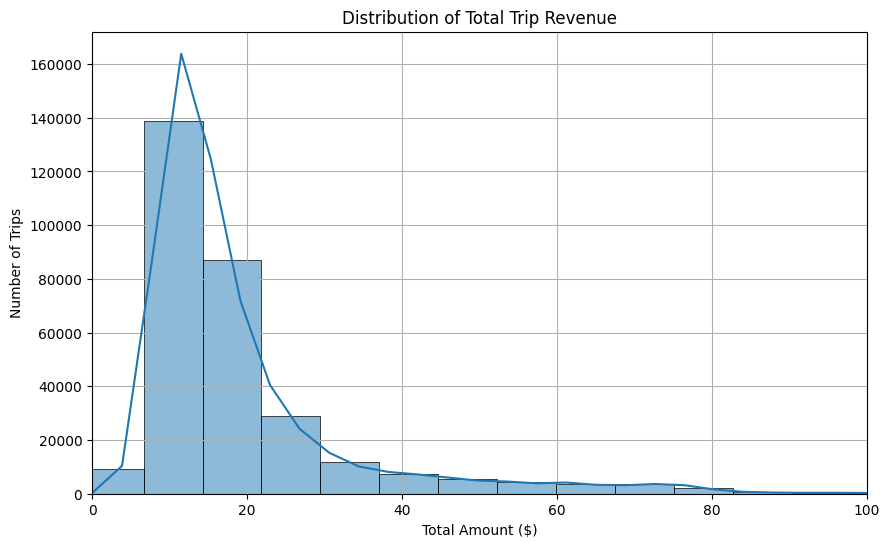

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_amount'], bins=100, kde=True)
plt.xlim(0, 100)
plt.title('Distribution of Total Trip Revenue')
plt.xlabel('Total Amount ($)')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


#### Average Revenue per Trip by Hour of Day 
The average revenue per trip varies throughout the day, revealing important patterns:

- Early morning hours (4 AM–5 AM) record the highest average revenue, peaking at roughly $24 around 4 AM, likely due to airport runs or longer trips during low-traffic hours.
- Midday to early evening (7 AM–7 PM) shows relatively stable revenue, averaging around $17–$20, reflecting high trip volume but shorter distances.
- Late-night hours (12 AM–3 AM) also show slightly elevated revenue (~$19–$20), possibly due to longer trips or higher fares during off-peak hours.
- Overall, while trip volume may peak during business hours, revenue per trip is higher during early mornings and late nights, suggesting these are more profitable time windows for drivers.

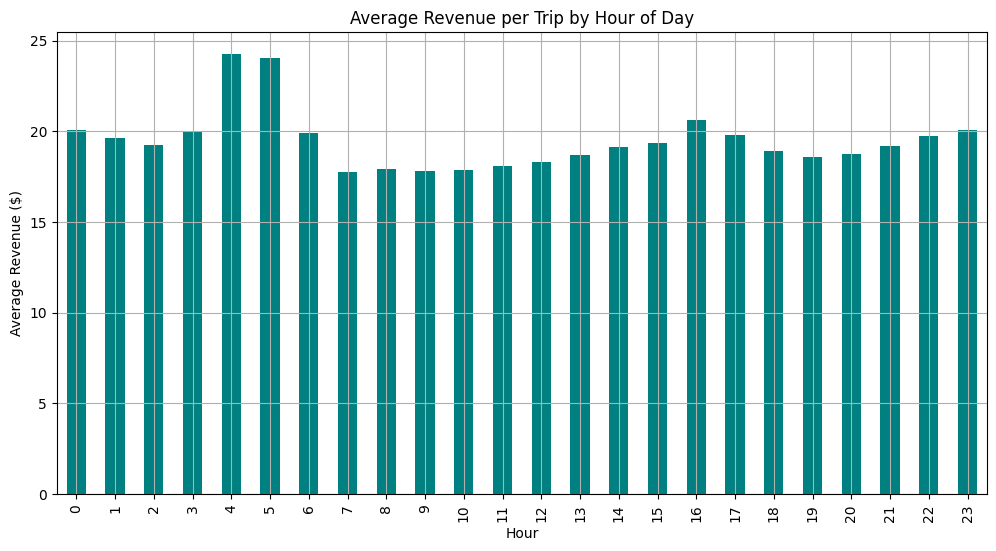

In [59]:
revenue_by_hour = df.groupby('pickup_hour')['total_amount'].mean()

plt.figure(figsize=(12, 6))
revenue_by_hour.plot(kind='bar', color='teal')
plt.title('Average Revenue per Trip by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Revenue ($)')
plt.grid(True)
plt.show()


#### Average Revenue per Trip by Pickup Borough 
The average revenue per trip varies significantly by pickup borough, highlighting key geographic trends:

- EWR (Newark Airport) has the highest average fare at roughly $90, followed by Staten Island (roughly $76) and Queens ( roughly $47)  likely due to longer trip distances and flat-rate airport fares.
- Bronx (roughly $31) and Brooklyn (roughly $26) show moderate average fares, reflecting a mix of local and inter-borough travel.
- Manhattan, despite being the most active borough, has the lowest average fare (roughly $16), indicating a high volume of short-distance trips.

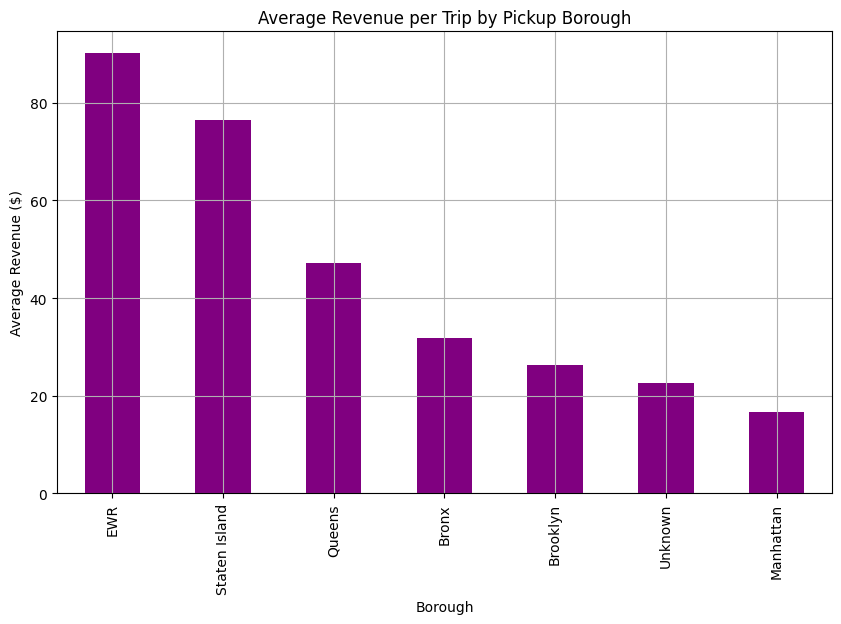

In [62]:
revenue_by_borough = df.groupby('pickup_borough')['total_amount'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
revenue_by_borough.plot(kind='bar', color='purple')
plt.title('Average Revenue per Trip by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Average Revenue ($)')
plt.grid(True)
plt.show()


#### Top High-Revenue Routes 
The highest average revenue trips are primarily associated with long-distance travel, especially to or from areas outside of NYC:

- The route from Gramercy to Outside of NYC records the highest average fare at $241.24, followed by Longwood to West Concourse ($216.82) and Randalls Island to Outside of NYC ($212.36).
- Several high-revenue trips originate from Manhattan, Queens, and airport zones (like JFK Airport to Arden Heights), indicating that airport transfers and inter-county trips are among the most profitable.
- The "Outside of NYC" drop-off zone appears frequently, confirming that outbound trips (likely to New Jersey or Long Island) have significantly higher fares.


In [66]:
high_revenue_routes = df.groupby(['pickup_zone', 'dropoff_zone'])['total_amount'].mean().reset_index()
high_revenue_routes = high_revenue_routes.sort_values(by='total_amount', ascending=False).head(10)
high_revenue_routes


,pickup_zone,dropoff_zone,total_amount
4822,Gramercy,Outside of NYC,241.235000
7323,Longwood,West Concourse,216.820000
9817,Randalls Island,Outside of NYC,212.360000
12262,Upper West Side North,Outside of NYC,202.800000
3776,Elmhurst/Maspeth,Outside of NYC,201.900000
4026,Financial District South,Outside of NYC,199.136667
5401,Howard Beach,Outside of NYC,185.540000
4271,Flatlands,Outside of NYC,184.740000
5335,Highbridge Park,Outside of NYC,172.550000
5569,JFK Airport,Arden Heights,168.770000


### Task 3: Trip Demand Forecasting

XGBoost was selected for its ability to handle non-linear relationships and complex interactions between features

In [80]:
df['pickup_date'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date
daily_demand = df.groupby('pickup_date').size().reset_index(name='trip_count')

# Convert to datetime index
daily_demand['pickup_date'] = pd.to_datetime(daily_demand['pickup_date'])
daily_demand.set_index('pickup_date', inplace=True)

daily_demand.head()


,trip_count
pickup_date,
2018-01-01,135
2018-01-02,136
2018-01-03,152
2018-01-04,70
2018-01-05,151


#### Feature Engineering:

Created lag features (lag_1 to lag_7) to capture short-term temporal dependencies.
Added calendar-based features such as day_of_week and is_weekend to capture weekly seasonality.

In [117]:
# Create lag features previous 7 days trip counts
for lag in range(1, 8):  
    daily_demand[f'lag_{lag}'] = daily_demand['trip_count'].shift(lag)
# Drop rows with NaN values
daily_demand.dropna(inplace=True)

daily_demand['day_of_week'] = daily_demand.index.dayofweek  
daily_demand['is_weekend'] = daily_demand['day_of_week'] >= 5



##### Train-Test Split:

Used the last 14 days of data as the test set to evaluate future forecasting performance.


In [118]:
# Usng the last 14 days as test set
train = daily_demand.iloc[:-14]
test = daily_demand.iloc[-14:]

X_train = train.drop('trip_count', axis=1)
y_train = train['trip_count']
X_test = test.drop('trip_count', axis=1)
y_test = test['trip_count']


#### Model Tuning:

Performed GridSearchCV to optimize n_estimators, learning_rate, and max_depth.
Used 5-fold cross-validation with negative RMSE as the scoring metric.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='neg_mean_squared_error',  
    verbose=1,
    n_jobs=-1  
)


grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (CV):", (-grid_search.best_score_)**0.5)

best_model = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Best RMSE (CV): 22.603951431724678


#### Model Evaluation:

Achieved strong performance on the test set:
MAE: 5.84 trips
RMSE: 8.09 trips
R² Score: 0.77
These metrics indicate the model captures 77% of the variance in daily demand with low prediction error.

In [120]:
y_pred = grid_search.best_estimator_.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² Score:", r2_score(y_test, y_pred))


Test MAE: 5.849697657993862
Test RMSE: 8.098760779866469
Test R² Score: 0.7752041816711426


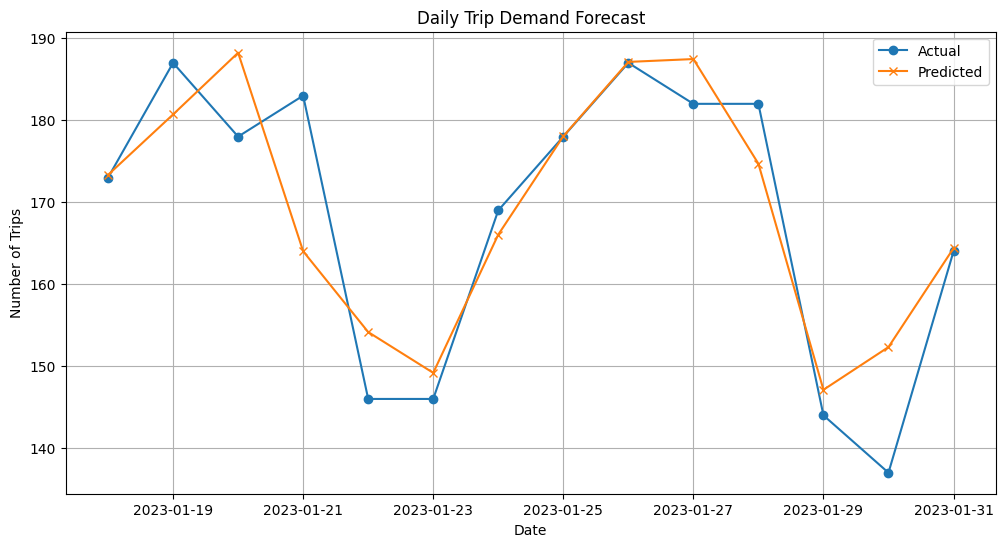

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.title('Daily Trip Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()


#### Forecasting:

Used the trained model to predict next-day demand by shifting lag features forward and updating date variables.

In [124]:
# Use the last available row to predict the next day
latest = daily_demand.iloc[-1:].copy()

# Shift lag features forward
for i in range(7, 0, -1):
    latest[f'lag_{i}'] = daily_demand.iloc[-i]['trip_count']

latest['day_of_week'] = (latest.index[-1].dayofweek + 1) % 7
latest['is_weekend'] = latest['day_of_week'] >= 5

# Predict next day
next_day_prediction = best_model.predict(latest.drop('trip_count', axis=1))
print(f"Predicted trips for next day: {int(next_day_prediction[0])}")


Predicted trips for next day: 174
